In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07.ipynb")

# Lab 7: Nonparametric methods

The goal of this lab is to explore and interpret several nonparametric methods for regression.

The code you need to write is indicated with `...`. There is additional documentation for each part as you go along.

In preparation for this lab, we would recommend that you review the slides and demos from Lectures 13 and 14.

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

`<Collaborator Name> <Collaborator e-mail>`

## Submission
See the [Gradescope Submission Guidelines](https://edstem.org/us/courses/42657/discussion/3350112) for details on how to submit your lab.

Again, since this lab involves training many different models, **tests may take awhile to run. Submit as early as possible, as last minute submissions may overwhelm datahub, preventing yourself and others from submitting on-time.** If you are having difficulties with submitting the lab on time, please see [this thread](https://edstem.org/us/courses/52891/discussion/4327459?comment=10041901) on Ed.

**For full credit, this assignment should be completed and submitted before Wednesday, March 13th, 2023 at 5 PM PT.**

In [4]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

sns.set()

import hashlib
def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

# 1. Model comparison

In this lab, we'll be working with the hybrid car dataset ([which you may remember from Data 8](https://inferentialthinking.com/chapters/15/1/Correlation.html)).

It contains data on 153 different models of hybrid car from 1997 to 2013, with the price (`msrp`), gas mileage (`mpg`), type of car (`class`), and how fast the car accelerates in km/hour/second (`acceleration`).

We're going to try to predict the price using other features of the car.

In [5]:
hybrid = pd.read_csv('hybrid.csv')

X_cols = ["year", "acceleration", "mpg"] # Columns used for prediction
y_col = "msrp" # The column we're trying to predict

hybrid

,vehicle,year,msrp,acceleration,mpg,class
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact
1,Tino,2000,35354.97,8.20,54.10,Compact
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact
3,Insight,2000,18936.41,9.52,53.00,Two Seater
4,Civic (1st Gen),2001,25833.38,7.04,47.04,Compact
...,...,...,...,...,...,...
148,S400,2013,92350.00,13.89,21.00,Large
149,Prius Plug-in,2013,32000.00,9.17,50.00,Midsize
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize


This cell generates all pairs of scatterplots for numerical variables in the data. You should see the same trends discussed in the chapter of the Data 8 textbook linked above.

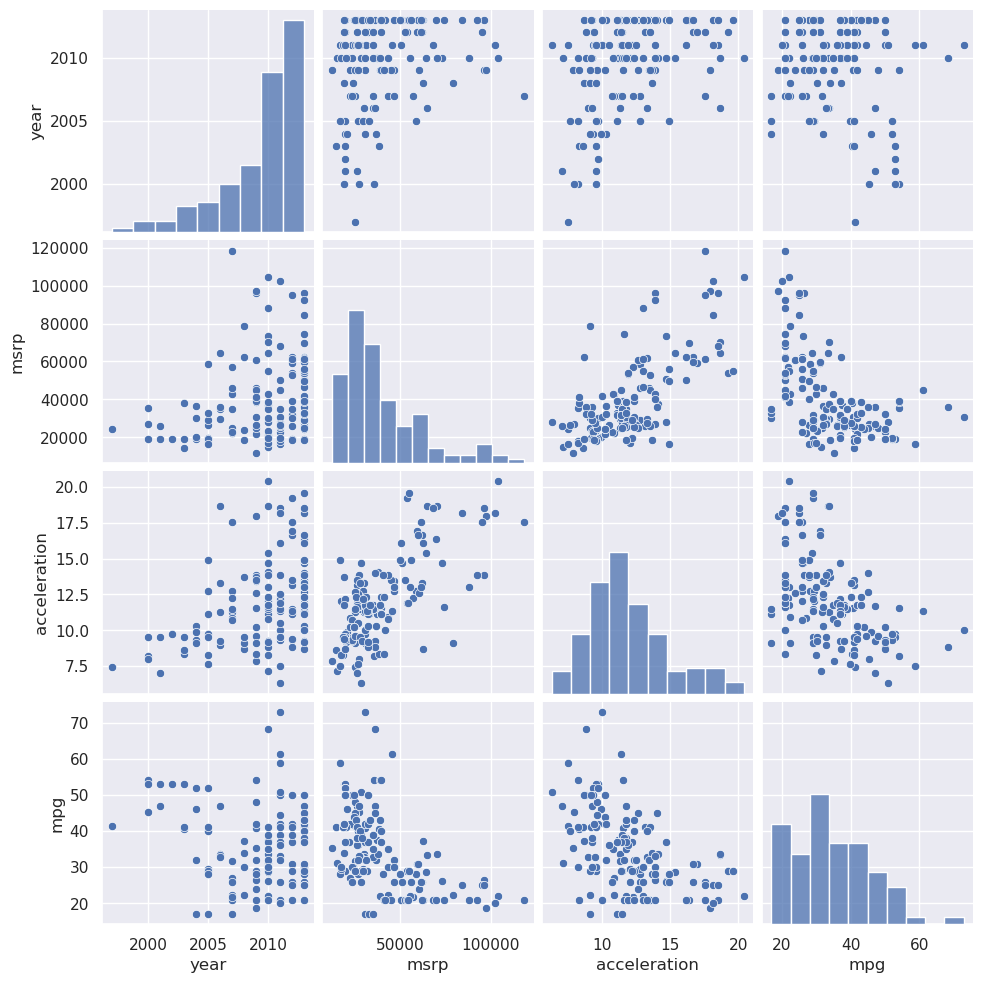

In [6]:
sns.pairplot(hybrid)

### 1(a) Splitting the data

We'll start by splitting the data into training and test sets. Use the scikit-learn function `train_test_split` to make two dataframes called `train` and `test`. The test set should have $30\%$ of the data (46 rows).

The `train_test_split` function has an argument called `random_state` that lets you ensure that it uses the same random split every time: you should set that argument to `101` to pass the tests.

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(hybrid, test_size=0.3, random_state=101)

In [9]:
grader.check("q1a")

q1a results: All test cases passed!

### 1(b) Predicting the output

#### 1.b.(i) Linear regression

Use linear regression to predict the MSRP from year, acceleration, and MPG. Add a new column to the `train` and `test` dataframes called `linear_pred` with the predictions from linear regression.

*Hint: throughout this lab, you should use the default values of all parameters for all models we're experimenting with.*

*Hint: for this lab, you don't need to worry about `pandas` warnings about setting a value on a copy of a slice.*

In [11]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

X = train.loc[:, X_cols] 
y = train.loc[:, y_col] 
linear_model.fit(X, y)
train["linear_pred"] = linear_model.predict(train.loc[:, X_cols])
test["linear_pred"] = linear_model.predict(test.loc[:, X_cols])

In [12]:
grader.check("q1b_i")

q1b_i results: All test cases passed!

Run the following cell that computes the training set error and test set error.

In [13]:
train_rmse = np.mean((train["linear_pred"] - train["msrp"]) ** 2) ** 0.5
test_rmse = np.mean((test["linear_pred"] - test["msrp"]) ** 2) ** 0.5

print("Training set error for linear model:", train_rmse)
print("Test set error for linear model:    ", test_rmse)

Training set error for linear model: 14189.994426186666
Test set error for linear model:     15977.338415318834


#### 1.b.(ii) Decision Trees

Recall that a decision tree is a method for classification and regression that uses a tree-like structure to decide what value to predict for a point.


In this question, we'll use a decision tree for regression instead of classification. When we built a decision tree for classification in lecture, we made decisions about splitting based on how homogeneous the $y$-values were. Now, we'll instead make splits based on the residuals for predicting at that node. 

Let's look at an example, assuming we're using mean squared error as our loss. For example, if we make our first split based on whether or not `mpg <= M`, we'll have some average MSRP for the low-MPG cars (below `M`), along with residuals if we used that average to predict the MSRP for all the low-MPG cars. Similarly, we have the same information for the high-MPG cars (above `M`). A good value of `M` will make the mean squared residuals for the two groups as small as possible. So, at each node, we choose a split that makes the mean squared error on each side as small as possible.

Compute the prediction from a decision tree with the default parameters for scikit-learn's `DecisionTreeRegressor` (i.e., no limit on tree depth). Add a new column to the `train` and `test` dataframes called `tree_pred` with the predictions from the decision tree.

*Hint: your code should look very similar to your answer from 1.b.(i).*

In [14]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()

# BEGIN SOLUTION
X = train.loc[:, X_cols] 
y = train.loc[:, y_col] 
tree_model.fit(X, y)
train["tree_pred"] = tree_model.predict(train.loc[:, X_cols]) # SOLUTION
test["tree_pred"] = tree_model.predict(test.loc[:, X_cols]) # SOLUTION
# END SOLUTION

In [15]:
grader.check("q1b_ii")

q1b_ii results: All test cases passed!

Run the following cell that computes the training set error and test set error.

In [16]:
train_rmse = np.mean((train["tree_pred"] - train["msrp"]) ** 2) ** 0.5
test_rmse = np.mean((test["tree_pred"] - test["msrp"]) ** 2) ** 0.5

print("Training set error for decision tree:", train_rmse)
print("Test set error for decision tree:    ", test_rmse)

Training set error for decision tree: 0.0
Test set error for decision tree:     14903.227222006093


#### 1.b.(iii) Random Forest

Recall that a random forest is the combination of a large number of decision trees.

Compute the prediction from a decision tree using scikit-learn's `RandomForestRegressor`, with the following parameters:
* 100 trees (default)
* no limit on each tree's depth (default)
* Use the `max_features` parameter to only use one feature for each tree. (*The recommended value for random forests is for each tree to only use 1/3 of the features, and in this case we have 3 features.*)

Add a new column to the `train` and `test` dataframes called `forest_pred` with the predictions from the random forest.

*Hint: your code should look very similar to your answers from 1.b.(i) and 1.b.(ii).*

In [18]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(max_features=1)

# BEGIN SOLUTION
X = train.loc[:, X_cols] 
y = train.loc[:, y_col] 
forest_model.fit(X, y)
train["forest_pred"] = forest_model.predict(train.loc[:, X_cols])
test["forest_pred"] = forest_model.predict(test.loc[:, X_cols])
# END SOLUTION

In [19]:
grader.check("q1b_iii")

q1b_iii results: All test cases passed!

Run the following cell that computes the training set error and test set error.

In [20]:
train_rmse = np.mean((train["forest_pred"] - train["msrp"]) ** 2) ** 0.5
test_rmse = np.mean((test["forest_pred"] - test["msrp"]) ** 2) ** 0.5

print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 5186.379373104781
Test set error for random forest:     13146.628414948653


<!-- BEGIN QUESTION -->

### 1(c) accuracy comparison

Of the Decision Tree model and the Random Forest model, which one does best on the training set? Why? Which model does best on the test set? Why?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### 1.d Interpretability

#### 1.d.i Linear Regression

Let's look at the coefficients from the linear regression model:

In [21]:
# You can just run this cell to print out the coefficients for each feature:
print(X_cols)
linear_model.coef_

['year', 'acceleration', 'mpg']


array([  51.19731259, 3910.97418313, -612.11460314])

<!-- BEGIN QUESTION -->

Using this result, fill in the blanks in the following two statements:

"Each year, linear regression predicts that the average price changes by $\$ \rule{1cm}{0.15mm}$ ". (Your answer should be a positive or negative number)

"Linear regression predicts that cars with better gas mileage are $\rule{1cm}{0.15mm}$ expensive." (Your answer should be either 'more' or 'less')

_Type your answer here, replacing this text._

<!-- END QUESTION -->

#### 1.d.ii Decision trees

We'll use the `plot_tree` function to draw the decision tree:

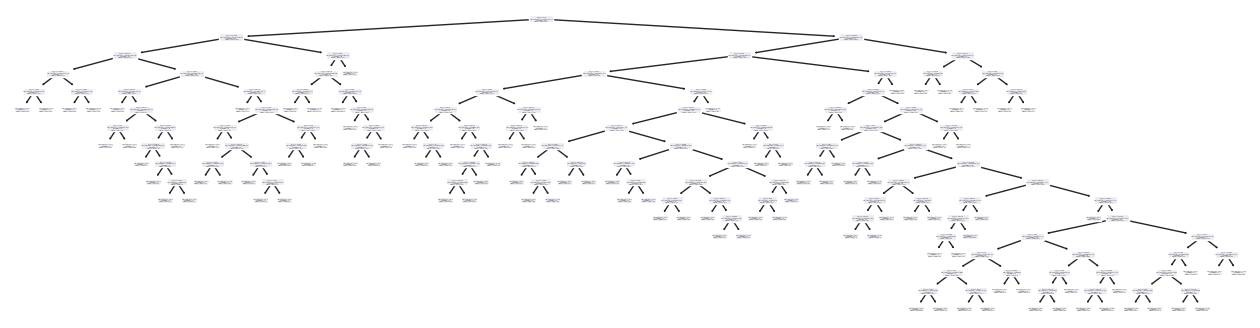

In [22]:
from sklearn.tree import plot_tree
plt.figure(figsize=(16, 4))
plot_tree(tree_model);

We can see that the tree is quite deep and complex. Let's take a closer look at the nodes at the top:

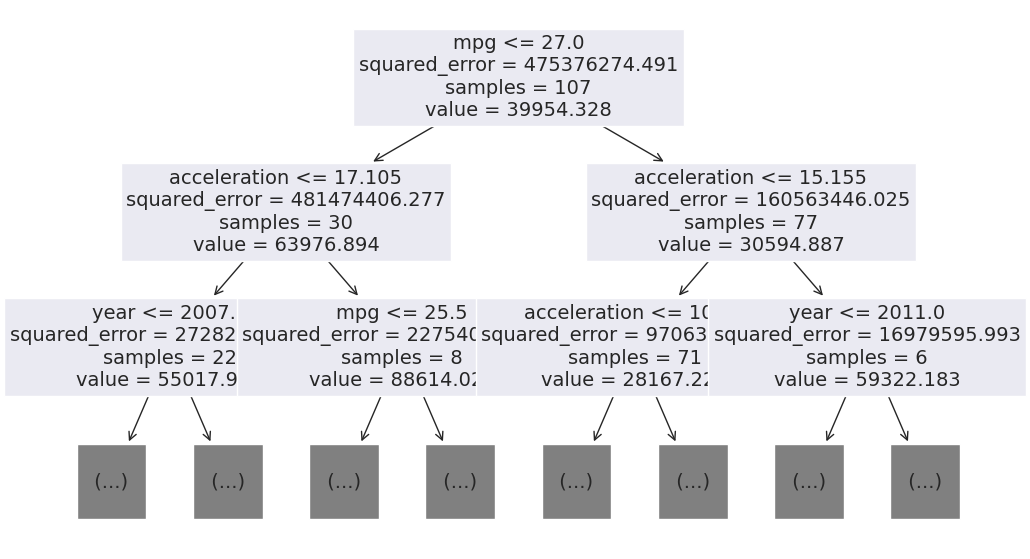

In [23]:
plt.figure(figsize=(12, 7))
plot_tree(tree_model, max_depth=2, fontsize=14, feature_names=X_cols);

There are a few things we can see right away:


* The first line tells us which feature to split on: values below the threshold go to the left, and values above go to the right.
* The third line tells us the number of training samples that made it that far into the tree.
* The fourth line tells us the average $y$-value (in this case, MSRP) of all the training samples that made it that far into the tree.

<!-- BEGIN QUESTION -->

Just by looking at the first few layers, we can already see that the decision tree has pulled out the most expensive cars into some of the branches, and the less expensive ones into other branches.

Suppose we had stopped growing the tree at this point. That would have given us four leaf nodes, each with very different mean MSRP. Describe the node that contains the most expensive cars in plain English.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

#### Random Forests

Unfortunately, random forests are much harder to interpret than either of the other two methods that we've tried. In this case, with so few features, we might be able to look at the top of each tree and find similarities across most or all of the trees, but in high-dimensional problems, each tree should see a very different subset of features, and this becomes much harder.

# 2. Explanations

Many methods for explainable ML use the following setup to explain a specific prediction from a complex model:

1. Construct a simpler, easier-to-explain model (e.g., linear regression, decision tree, etc.) that behaves similarly to the complex model for data points near the specific point we're trying to explain.
2. Interpret the simpler model.

In this question, we'll try to see if we can come up with an explanation for the worst predictions from each model.

### 2.a Linear Regression

#### 2.a.i Finding the worst predictions

Find the two cars in the test set where linear regression does the worst (i.e., has the highest absolute error). Your answer should be a dataframe with two rows from `test`, one for the worst error followed by one for the second-worst error. While solving this problem, you can add extra columns to `test` if you wish.


In [24]:
# Hint: There are a couple of ways to do this. One suggestion is to first create new column with the 
# absolute linear error and then sort the dataframe based on this absolute linear error.

test["abs_linear_error"] = np.abs(test["linear_pred"] - test["msrp"])
worst_linear_predicted_cars_df = test.sort_values("abs_linear_error", ascending=False).take([0, 1])

In [25]:
grader.check("q2a_i")

q2a_i results: All test cases passed!

In [26]:
worst_linear_predicted_cars_df

,vehicle,year,msrp,acceleration,mpg,class,linear_pred,tree_pred,forest_pred,abs_linear_error
29,Lexus LS600h/hL,2007,118543.60,17.54,21.00,Midsize,69308.639296,97237.90,73093.4264,49234.960704
43,S400 Long,2009,96208.93,13.89,26.34,Large,51867.286172,44903.77,51330.6786,44341.643828


<!-- BEGIN QUESTION -->

#### 2.a.ii Explanation

Using the coefficients of the linear model that we found earlier, explain why linear regression's predictions for these two cars were the way they were. Is the explanation from the linear model consistent with the trends you observed at the beginning in the visualizations?

_Type your answer here, replacing this text._

<!-- END QUESTION -->

### 2.b: Random Forests

#### 2.b.i Finding the worst predictions for the random forest

Find the two cars in the test set where random forest does the worst (i.e., has the highest absolute error). Your answer should be a dataframe with two rows from `test`, one for each of the two cars. You can add extra columns to `test` if you wish.

*Hint: your code should be very similar to your code for 2.a.i.*

In [27]:
test["abs_forest_error"] = np.abs(test["forest_pred"] - test["msrp"])
worst_forest_predicted_cars_df = test.sort_values("abs_forest_error", ascending=False).take([0, 1])

In [28]:
grader.check("q2b_i")

q2b_i results: All test cases passed!

In [29]:
worst_forest_predicted_cars_df

,vehicle,year,msrp,acceleration,mpg,class,linear_pred,tree_pred,forest_pred,abs_linear_error,abs_forest_error
29,Lexus LS600h/hL,2007,118543.60,17.54,21.00,Midsize,69308.639296,97237.90,73093.4264,49234.960704,45450.1736
43,S400 Long,2009,96208.93,13.89,26.34,Large,51867.286172,44903.77,51330.6786,44341.643828,44878.2514


# 3 Feature Engineering and Interpretability

In this question, we will be exploring the effect of feature engineering on the interpretability of a given model using a toy dataset. Let's start by loading the data, which has already been split for you into train and test sets:

In [30]:
# This is the same plotting function from lecture

def draw_results(x1, x2, color, plot_title=''):
    plt.figure()
    plt.scatter(x1, x2, c=color, cmap='viridis', alpha=0.7);
    plt.colorbar()
    plt.title(plot_title)
    plt.axis('equal')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.tight_layout()

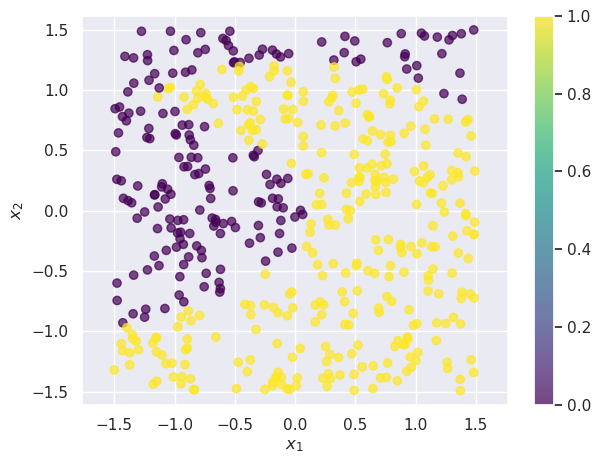

In [32]:
# Import datasets
ring_train = pd.read_csv('ring_train.csv')
ring_test = pd.read_csv('ring_test.csv')
draw_results(ring_train['x1'], ring_train['x2'], color=ring_train['y'])

We know from lecture that without any additional features, logistic regression will use a line as a decision boundary. 
Where would you draw the best line to classify these points? (No need to answer, but please think about it.)

We are now going to fit a simple logistic regression model on the data using the following lines of code. 

In [33]:
# No need to write any code here: just understand.
X_train = ring_train[['x1', 'x2']].values
y_train = ring_train['y'].values

X_test = ring_test[['x1', 'x2']].values
y_test = ring_test['y'].values

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy on test set: 0.7933333333333333


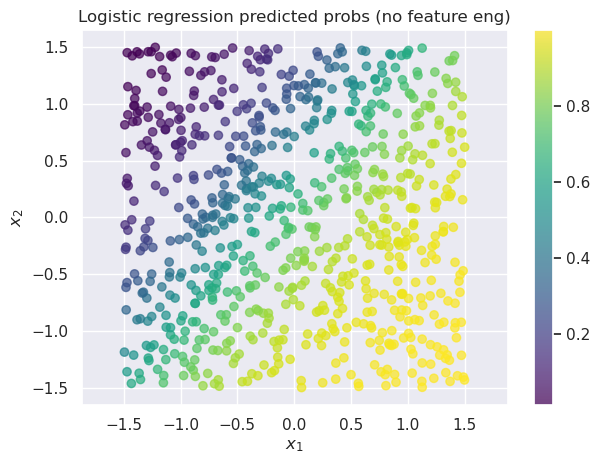

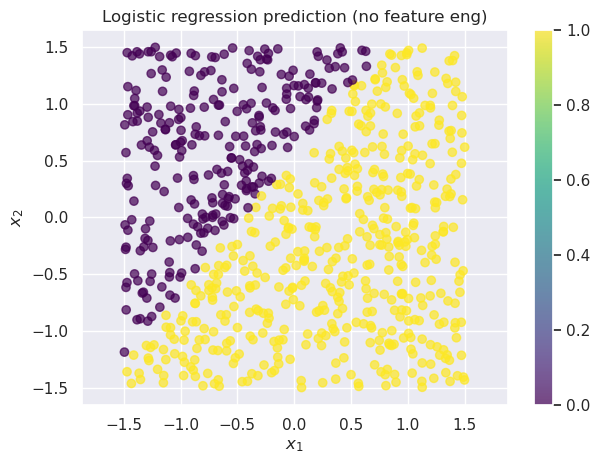

In [34]:
# No need to write any code here: just understand.
from sklearn.linear_model import LogisticRegression

X_train = ring_train[['x1', 'x2']].values
y_train = ring_train['y'].values

X_test = ring_test[['x1', 'x2']].values
y_test = ring_test['y'].values

model_simple_features = LogisticRegression(
    penalty='none', solver='lbfgs'
)

model_simple_features.fit(X_test, y_test)

probs = model_simple_features.predict_proba(X_test)[:, 1]
y_hat = (probs > 0.5).astype(np.int64)

draw_results(
    X_test[:, 0], X_test[:, 1], color=probs, 
    plot_title="Logistic regression predicted probs (no feature eng)"
)
draw_results(
    X_test[:, 0], X_test[:, 1], color=y_hat, 
    plot_title="Logistic regression prediction (no feature eng)"
)

accuracy = np.mean(y_test == y_hat)
print(f"Accuracy on test set: {accuracy}")

Comparing the labels classified by the model with the true labels, we notice that the simple logistic regression model is not ideal partly because the true decision boundary is nonlinear. In order to improve on the model, we will engineer new features. 

With the checkerboard dataset, we engineered a new feature, $x_1 \times x_2$, which was just what we needed. For this dataset, the feature that we need is a little more complicated.

Instead, we'll take inspiration from neural networks, and add many random features, where each is a random linear combination of the inputs, where the coefficients will be random numbers between -1 and 1.

Don't forget that we also need to apply a nonlinearity, or else the linear combinations won't help us when applying logistic regression. In this example, we'll use the sigmoid function. For example, one feature might be $\sigma(-0.37x_1 + 0.82x_2)$.

### 3.a Add random features

Complete the cell below to add random features to the dataset. As described above, we first generate a pair of coefficients $(c_1, c_2)$ uniformly random from $(-1, 1)$ and then for both the training set and the test set, add an additional column whose values are $\sigma(c_1x_1 + c_2 x_2)$.

In [35]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def add_random_feature(train_data, test_data):
    # Returns the modified train_data and test_data
    coeffs = np.random.uniform(-1, 1, 2)
    # This code gives the feature a convenient name
    feat_name = f"σ({coeffs[0]:0.2f}x1 + {coeffs[1]:0.2f}x2)"

    for dataset in (train_data, test_data):
        linear_combination = np.dot(dataset[['x1', 'x2']], coeffs)
        feature = sigmoid(linear_combination)
        dataset[feat_name] = feature
    return train_data, test_data

In [36]:
grader.check("q3a")

q3a results: All test cases passed!

Using the code you completed in 3a, we can now add 10 random features to both the training set and the test set using the following code:

In [37]:
# This cell uses the code you wrote to add 10 random features to the
# train and test sets.

ring_train_feats = ring_train.copy()
ring_test_feats = ring_test.copy()
for i in range(10):
    ring_train_feats, ring_test_feats = (
        add_random_feature(ring_train_feats, ring_test_feats)
    )
ring_train_feats.head()

,y,x1,x2,σ(-0.69x1 + -0.69x2),σ(-0.88x1 + 0.73x2),σ(0.20x1 + 0.42x2),σ(-0.96x1 + 0.94x2),σ(0.66x1 + -0.58x2),σ(-0.64x1 + -0.63x2),σ(-0.39x1 + 0.05x2),σ(-0.14x1 + -0.42x2),σ(0.22x1 + -0.72x2),σ(-0.42x1 + -0.27x2)
0,0,-0.188203,1.331702,0.312867,0.757976,0.626240,0.807215,0.290844,0.326632,0.534849,0.370418,0.268494,0.431019
1,1,-1.441836,-1.103109,0.852064,0.614550,0.320683,0.585588,0.419698,0.834241,0.624779,0.658551,0.616048,0.709761
2,1,-0.028040,-0.675134,0.618642,0.384698,0.428831,0.352603,0.591405,0.609529,0.494388,0.570946,0.617868,0.547879
3,1,1.008068,0.051442,0.325435,0.298743,0.556080,0.285321,0.654901,0.337589,0.403205,0.460411,0.546966,0.393455
4,1,-1.104465,-1.197234,0.829705,0.524821,0.327045,0.483459,0.488615,0.811671,0.592217,0.657061,0.649341,0.685493


We can now train a new logistic regression model with these 10 additional features.

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Accuracy on test set: 0.9213333333333333


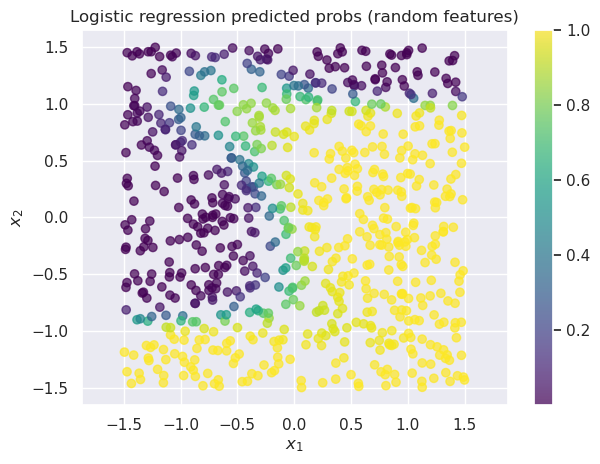

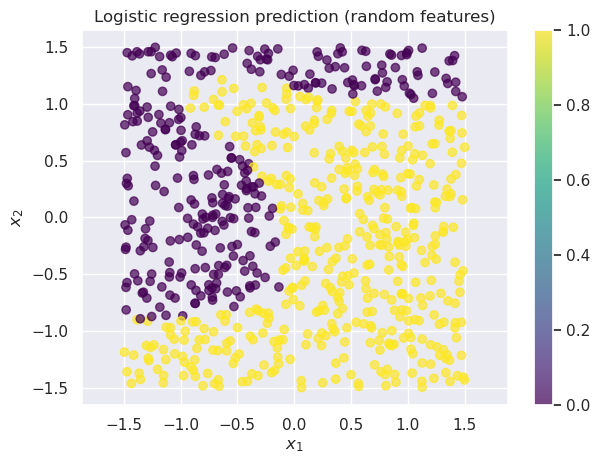

In [38]:
# No need to write any code here: just understand.
X_train = ring_train_feats.iloc[:, 1:].values
y_train = ring_train_feats['y'].values

X_test = ring_test_feats.iloc[:, 1:].values
y_test = ring_test_feats['y'].values

model_features = LogisticRegression(
    penalty='none', solver='lbfgs'
)

model_features.fit(X_train, y_train)

probs = model_features.predict_proba(X_test)[:, 1]
y_hat = (probs > 0.5).astype(np.int64)

draw_results(
    X_test[:, 0], X_test[:, 1], color=probs, 
    plot_title="Logistic regression predicted probs (random features)"
)

draw_results(
    X_test[:, 0], X_test[:, 1], color=y_hat, 
    plot_title="Logistic regression prediction (random features)"
)

accuracy = np.mean(y_test == y_hat)
print(f"Accuracy on test set: {accuracy}")

You should see that the accuracy is already better. Now that our model has improved, let's try to interpret it.

### 3.b Coefficients

Fill in the blanks in the following code that creates a dataframe with the coefficients from the logistic regression model.

*Hint: you may find it helpful to refer to the demo from lecture.*

In [ ]:
feature_names = ring_train_feats.columns[1:]
logistic_coeff_vals = ...
len(logistic_coeff_vals)
coefficient_df = pd.DataFrame(
    {'feature': feature_names, 'coefficients': logistic_coeff_vals}
)

coefficient_df

In [ ]:
grader.check("q3b")

<!-- BEGIN QUESTION -->

### 3c Interpretibility

This model has better performance on the data but at the same time, it loses some interpretability. Explain why this logistic regression model is harder to interpret than the simpler (and worse-performing) one from earlier.

_Type your answer here, replacing this text._

<!-- END QUESTION -->

## Congratulations! You have finished Lab 7!

## Well done!
You've reached the end of the lab! Make sure you double check your work and make sure that you've answered all the written portions of the lab.

Before you submit to Gradescope, make sure you pass all the autograded portions of this lab. **Run the cell below to generate a PDF of your lab submission**, and **run the last cell to generate a zip file of your lab submission.** Do **not** create your lab PDF by exporting your notebook to a PDF.

To submit your lab to Gradescope, submit the PDF to Lab 5 Written and the zip file to Lab 5 Code.

In [ ]:
import matplotlib.image as mpimg
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("lab07.ipynb", filtering=True, pagebreaks=True)
if(path.exists('lab07.pdf')):
    img = mpimg.imread('gecko.jpg')
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()
    display(HTML("Download your PDF <a href='lab07.pdf' download>here</a>."))
else:
    print("\n Pdf generation fails, please try the other methods described above")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)